# Iowa Housing analysis

## Table of Contents
- <a href="#EDA">Exploratory Data Analysis</a><br>
    - <a href="#NA">Recognizing reasons for Null values</a><br>
    - <a href="#Price">Price Distribution</a><br>
    - <a href="#CatNum">Differences between Categorical and Numerical values</a><br>
    - <a href="#Corr">Comparing data through correlation matrix</a><br>
    - <a href="#Col">Analysis of each Column</a><br>
- <a href="#Talk">Discussion</a><br>
    - <a href="#Change">Columns that were removed/adjusted from feature list</a><br>
    - <a href="#Outliers">Outliers</a><br>
    - <a href="#R_P">Differences between R and Python Analysis</a><br>
- <a href="#ML">Combining R and Python analysis for Machine Learning</a><br>
- <a href="#test">Preparing test file for prediction</a><br>

In [1]:
# Load Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

<p><a name="EDA"></a></p> 

# Exploratory Data Analysis

In [2]:
# Load Data
data = pd.read_csv('train.csv')

# Looking at Data
data.sample()
data.tail()
data.describe()
data.shape

(1460, 81)

<p><a name="NA"></a></p>

### Recognizing reasons for Null values 
- LotFrontage is numerical feet of street connected to property.
- Alley is catergorical type of ally. NA represents no ally
- MasVnrType is Mansonry Veneer type. NA represents none
- Bsmt NA is no basement
- Electrical has no caterigory for NA. Insepection needed.
- FireplaceQu NA is no fireplace
- GarageType NA is no Garage
- PoolQC NA is no pool
- Fence NA is no Fence
- MiscFeature NA is no misc features

In [3]:
bsmt = data.filter(regex = 'Bsmt.+')
bsmt.columns

col_na= data.columns[data.isna().any()] #Basements that do not have basements are listed as N/a
col_na.shape

(19,)

<p><a name="Price"></a></p>

### Price Distribution

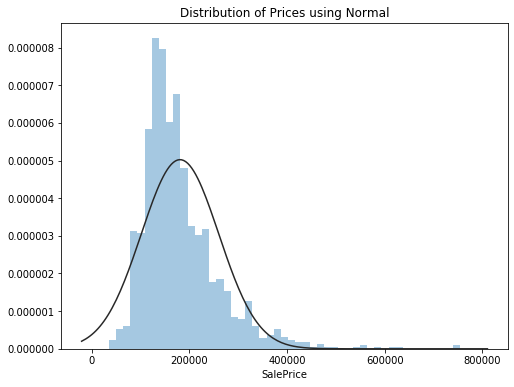

In [4]:
#### Learning to recognize distribution of prices ####

f, axes = plt.subplots(figsize = (8,6) )
fig = sns.distplot(data.SalePrice, kde = False, fit = stats.norm).set_title('Distribution of Prices using Normal')
    # kde is a boolean for ploting a gaussian kernal density estimate
    # fit uses the probability norm function from scipy, represented in the blank line

models work better with symmetric gaussian distributions, therefore we want to get rid of the skewness.

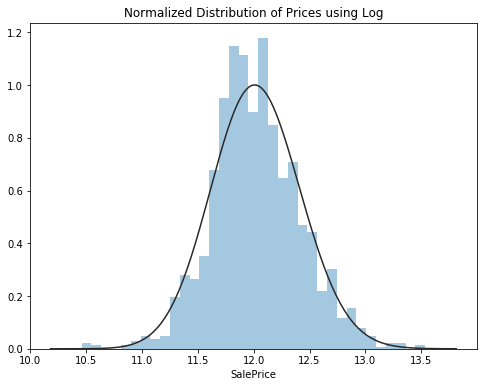

In [5]:
f,axes = plt.subplots( figsize= (8,6) )
fig = sns.distplot(np.log(data.SalePrice), kde = False, fit= stats.lognorm).set_title('Normalized Distribution of Prices using Log')

<p><a name="CatNum"></a></p>

### Differences between Categorical and Numerical values

In [6]:
### Differntiate categorical and numerical values ###

data['MSSubClass'] = data['MSSubClass'].astype(object)
cat_columns = data.select_dtypes(include = ['object']).columns
cat_data = data[cat_columns]

num_columns = data.select_dtypes(exclude = ['object']).columns
num_data = data[num_columns]
num_data = num_data.drop('SalePrice', axis =1).drop('Id', axis =1)

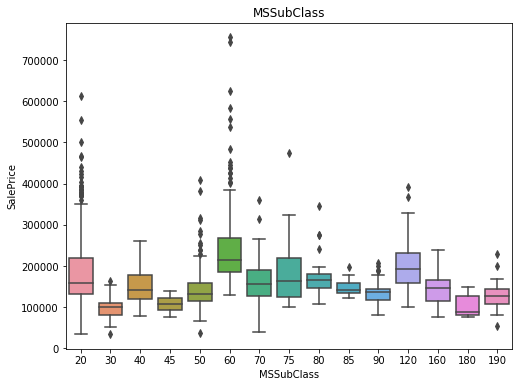

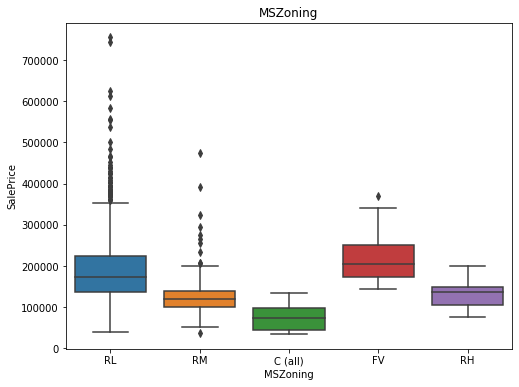

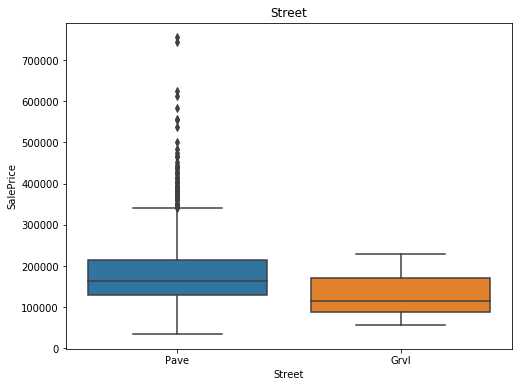

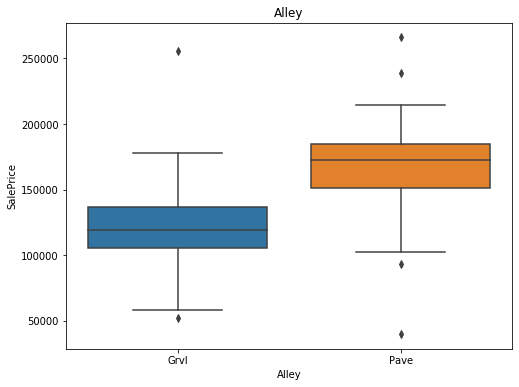

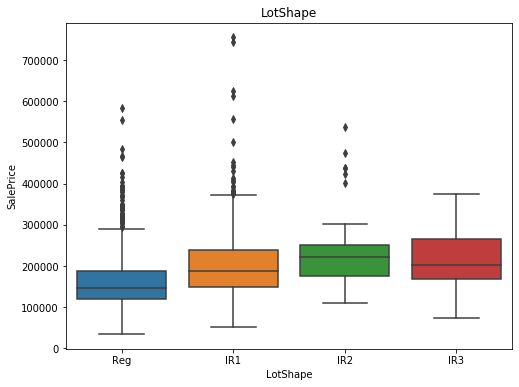

In [7]:
#Box plots for catagorial data
for colm in cat_columns[:5]:
    temp = pd.concat( [ data.SalePrice, data[colm] ], axis=1)
    f, axes = plt.subplots(figsize = (8,6) ) #figure and axies
    fig = sns.boxplot( x= colm, y= 'SalePrice', data=temp).set_title('{}'.format(colm))

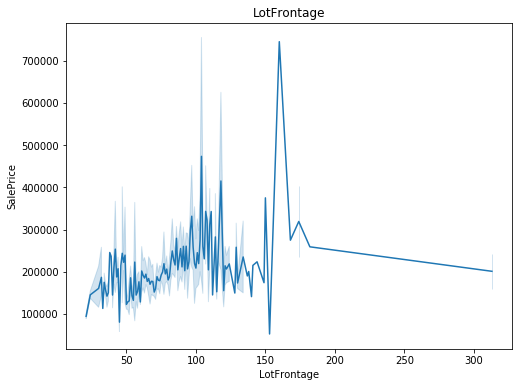

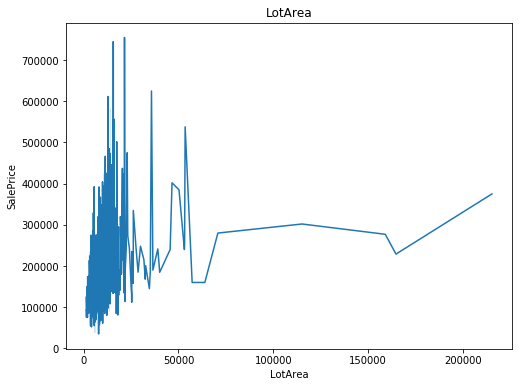

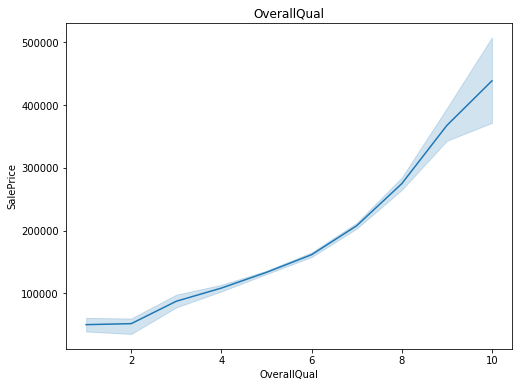

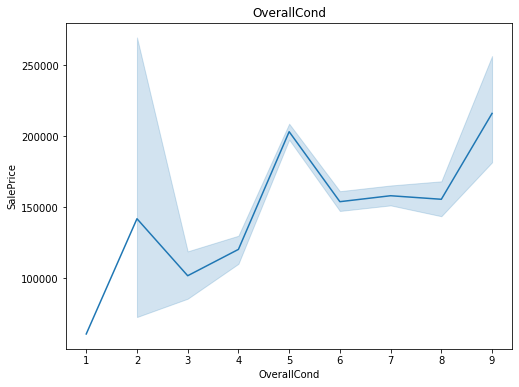

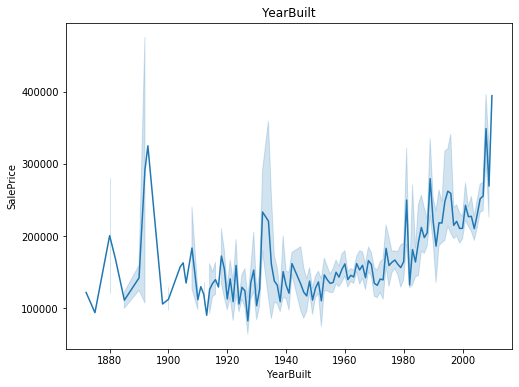

In [8]:
#Line graphs for numerical data
for colm in num_data.columns[:5]:
    temp = pd.concat( [data.SalePrice, data[colm] ], axis =1)
    f, axes = plt.subplots(figsize = (8,6) )
    fig = sns.lineplot( x= colm, y= 'SalePrice', data = temp).set_title('{}'.format(colm))

In [9]:
# Created a function that performs the same as the loops above

def cat_box(x, y='SalePrice'):
    '''
    Call x as a string of the desired column name.
    Creates a box plot of the desired column to the Sales Price. This is adjustable by calling y.
    Displays null values with 0
    '''
    t = data[x]
    t = t.fillna(0)
    temp = pd.concat( [ data[y], t ], axis =1)
    f, axes = plt.subplots( figsize =(8,6) )
    fig = sns.boxplot( x = x, y = y, data = temp).set_title('{}'.format(x))
    
def num_graph(x, y='SalePrice', plot='line'):
    '''
    Call x as a string of the desired column name.
    Creates a graph of the desired column to Sales Price. This is adjustable by calling y
    
    Plot types: line, scatter, trend
    '''
    temp = pd.concat( [ data[y],data[x], ], axis=1)
    f, axes = plt.subplots( figsize = (8,6) )
    
    if plot =='line':
        fig = sns.lineplot( x=x, y=y, data=temp).set_title('{}'.format(x))
    elif plot == 'scatter':
        fig = sns.scatterplot( x=x, y=y, data=temp).set_title('{}'.format(x))
    else:
        raise Exception('plot not set to line or scatter')

[nan 'Shed' 'Gar2' 'Othr' 'TenC']


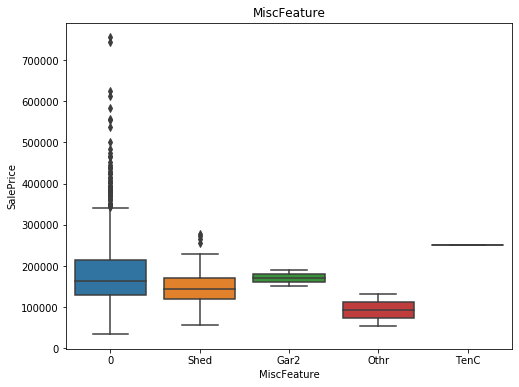

In [10]:
print(data.MiscFeature.unique())
cat_box('MiscFeature')

<p><a name="Corr"></a></p>

### Comparing data through correlation matrix

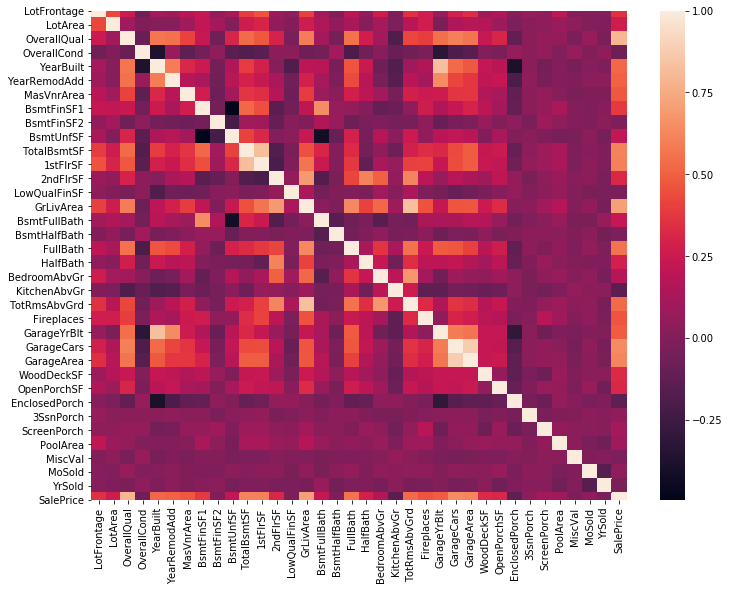

In [11]:
#Numerical correlation
corr_data = pd.concat( [num_data, data.SalePrice], axis=1)
raw_corr = corr_data.corr()
f, axes = plt.subplots(figsize = (12,9))
sns.heatmap(raw_corr)

The correlation matrix above has too many columns that makes it visually confusing. Therefore we need to identify the columns that are not useful. Some of the columns can become dummified

In [12]:
### Numerical Data check for NA values ###

num_data_cnt = num_data.agg(["count",'size','nunique']).T #size includes na values
num_data_cnt.sample()

,count,size,nunique
2ndFlrSF,1460,1460,417


In [13]:
### Catagorical Data check for NA values ###

cat_data_cnt = cat_data.agg(['count','size','nunique']).T
cat_data_cnt.sample()

,count,size,nunique
BsmtFinType1,1423,1460,6


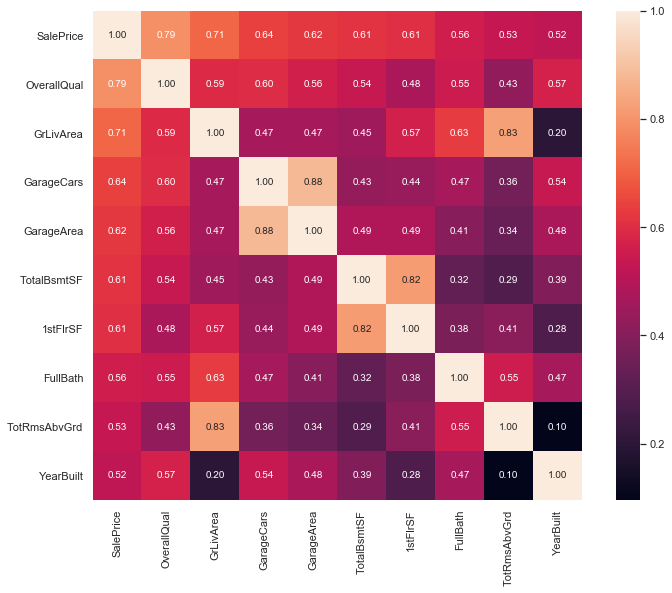

In [14]:
### Correlation Matrix of nth (10) largest values ###

colm_amt = 10
cols_corr = raw_corr.nlargest(colm_amt,'SalePrice')['SalePrice'].index #Gets list of highest correlations

corr_mat_sales = np.corrcoef(data[cols_corr].values.T) #Gets pearson correlation coefficient from traversed values of the columns
sns.set(font_scale = 1)
f, axes = plt.subplots(figsize = (12,9))
hm = sns.heatmap(corr_mat_sales, 
                 cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size':10},
                 yticklabels = cols_corr.values,
                 xticklabels = cols_corr.values
                )
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

<p><a name="Col"></a></p>

### Analysis of each Column

In [15]:
def data_type_check(colm, box=False):
    '''
    Function designed to investigate if a column is negligible.
    Set box to true for box plot. Plots only if the unique values are at or below 10.
    '''
    ratio = data[colm].count()/data[colm].size
    print('=*'*5, colm,'=*'*15, '\n',
          'Ratio between count and size: {}'.format(ratio),'\n',
          'Total number of 0\'s:', len(data[colm].loc[data[colm]==0,])
         )
    if len(data[colm].unique() ) <=50:
        print('{} unique values:'.format(colm), data[colm].unique() )
        if (len(data[colm].unique() ) <= 10) & (box==True):
            cat_box(colm)
    else:
        print('{} has over 50 unique values'.format(colm) )

In [16]:
# Loop an analysis of columns

for colm in data.columns:
    data_type_check(colm)

=*=*=*=*=* Id =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
Id has over 50 unique values
=*=*=*=*=* MSSubClass =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
MSSubClass unique values: [60 20 70 50 190 45 90 120 30 85 80 160 75 180 40]
=*=*=*=*=* MSZoning =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
MSZoning unique values: ['RL' 'RM' 'C (all)' 'FV' 'RH']
=*=*=*=*=* LotFrontage =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 0.8226027397260274 
 Total number of 0's: 0
LotFrontage has over 50 unique values
=*=*=*=*=* LotArea =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
LotArea has over 50 unique values
=*=*=*=*=* Street =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
Street unique values: ['Pave' 'Grvl']
=*=*=*=*=* Alley =*=*=*=*=*=*=*=*=*=*=*=*=*=*

In [17]:
# Creates a detailed report about data using Pandas Profiling

from pandas_profiling import ProfileReport
profile = ProfileReport(data, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_file(output_file="Boston_housing_data_report.html")

KeyboardInterrupt: 

<p><a name="Talk"></a></p>

# Discussion

<p><a name="Change"></a></p>

### Columns that were removed/adjusted from feature list

- **Street** There are only 6 rows of gravel out of 1460. Ratio is 0.4% **drop**
- **Alley** 90 rows with Alleys. Ratio 6.2% between alleys to overall. **drop**
- **LotShape** combine IR2 and IR3 together because there are only 41 and 10 rows respectively. **adjust**
- **LotConfig** 
- **Utilites** there is only 1 row with no sewage. **drop**
- **Landslope** combining moderate slope and Severe slope into one because low amount of rows and little difference when compared to Salesprice. **adjust** 1382 rows are 'Gtl'
- **Neighborhood** Too many catagories, should bin. Bin classification settings not defined.

- **Condition2** Too close with Condition1, but 99% of observations are Normal so not much predictive power for the other features. **drop**
- **BldgType** Bin smaller catagories into one because smaller observation count and similar distribution with Saleprice. Group ‘2FmCon’, ‘Duplex’, and ‘Twnhs’ into one category with ‘1Fam’ as the base model.
- **OverallCond** Too many outliers when compared with SalePrice, Linear regression model does not show significance
- **RoofMat1** drop
- **Bsmt** Basement types; after imputing the missing values for the Square Footage of Type 1 and Type 2, we deduced that only BsmtFinSF1 and TotalBsmtSF are significant predictors out of all the NUMERIC basement variables.
    - This shows that BsmtFinSF2 is not as significant in predicting the price as the P-value is significantly low when removing SF1 from the model or when working with the full model. BsmtFinSF1 is significant in all the variations of the model. Imputed a total finished SF of the basement and ran the model but could not find it to be of significance. **BsmtUnfSF did not** seem to be a good predictor; likely because of multicollinearity; recommend  we not use it for our model. YearBuilt, GarageArea, LotArea, BsmtFinSF1, and TotalBsmtSF are all significant
- **Heating** 1428 rows are labeled as GasA. Heating is essential in housing, this catagory will not drive sale prices. **drop**
- **HeatingQC** Bin poor (1), fair (49), good (241) into one. **adjust**
- **Centeral Air** 1365 rows have Yes, others are no. **drop**
- **Electrical** 1334 rows are SBrkr. Electrcity is essential in housing, this catagory will not drive sale prices. **drop** Note: There is 1 Na value.
- **FirstFlrSF** ID 1299 has an abnomrally large area for low sales prices. Team has addressed this row, currently not enough rationale to remove the outlier.
- **SecondFlrSF** 56.8% of the data are 0's, many of the houses do not have a second floor. This is an issue because locations with second floor shows an impact to sale price. The zero's will skew the regression. To appoarch this issue we will **create a new column** SecondFlr with 0/1 values.
- **LowQualFinSF** 1434/1460 listed as zeros, after comparing the 0 values and non-0 values to SalePrices, there weren't large noticing **drop**.
- **Baths** combine and drop BsmtFullBath, BsmtHalfBath, FullBath, HalfBath to **create** a new column **TotalBaths**
- **BedroomAbGr** Number of Bedrooms above grade (does not include bathrooms), Numerical
- **KitchenAbGr** Number of Kitchens above grade. 4 unique values, 1392 rows are 1. **drop**
- **KitchenQual** 4 unique catagories. Left to be **dummified**.
- **TotRmsAbvGrd** Total number of rooms. Numerical.
- **Functional** 7 unique catagories, 1360/1460 are listed as typ. Looking at a boxplot between Functional and SalePrice, the difference between columns other than typ can be group together. There is not enough rationale to drop this column. **Adjust** the column to 1 - typ 0 - damaged
- **Fireplaces** Number of fireplaces
- **FireplaceQu**  Catagorical values with the ratio betwen non-zero values and total rows is 0.5. Non-zero values can be dummified. **Adjust** the column to replace Nan  to **None**
- **GarageType** 81 rows as NA, no garage. Catagorical can be dummified.
- **GarageYrBlt** 81 0's. Data is in years. **GarageFinish** Catagorical. **GarageCars** Numerical. **GarageArea** Numerical. **GarageQual** 1311 rows are TA. **GarageCond** 1326 rows are TA. **PavedDrive** 1340 Y (yes).
    - Combine WoodDEckSF, OpenPorchSF, EnclosedPorced, 3SsnPorch, ScreenPorch into 1 column **PorchSF** . **WoodDeckSF** should be removed/adjusted because there are 761/1460 0's. **OpenPorchSF** should be removed/adjusted because there are 656/1460 0's. **EnclosedPorch** should be removed/adjusted because there are 1252/1460 0's. **3SsnPorch** should be removed/adjusted because there are 1436/1460 0's. **ScreenPorch** should be removed/adjusted because there are 1344/1460 0's
- **Pool** 0/1 value using poolarea and poolqc **PoolArea** should be removed because there are 1453/1460 0's. **PoolQc** should be removed because ratio between non-zero values and total rows is 0.04
- **Fence** should be removed because the column only displays fence quality, 281/1460 has Fence quality. Fence quality differences doesn't show large impact to SalePrice. **Adjust** Fence to 0/1.
- **MiscFeature** should be **adjusted** to 0/1 because there are only 54 rows with values. If there is a feature, **MiscVal** will list the value. 
- **MoSold** displays the month when the house was sold. **ordinal**


- Columns with years will need to be changed. Create 3 features that compare the differeneces:
    - sold - remodel
    - sold - built
    - remodel - built
    - Afterwords, Drop **YearBuilt**,**YearRemodAdd**, **YrSold**
- MasVnrType and MasVnrArea, zeros do not match so impute MasVnrType that is Nan will be binned with None. If MasVnrType is None and has an insignificiant area (<1), then the area will be changed to 0.00001.
- **GarageYrBuilt** shows that the frequency of Garages built long after the house was built is very low could result in multicollinearity.Even thoughh GarageYrBlt linear model has a low p-value and good R^2, there is a correlation with YearBuilt. **drop**

<p><a name="Outliers"></a></p>

### Outliers
- **LotFrontage** ID:935, 1299
- **BsmtFinSF1** ID 1299
- **BsmtFinSF2** ID 323
- **1stFlrSF** ID 1299
- **TotRmsAbvGrd** ID 636

<p><a name="R_P"></a></p>

### Differences between R and Python Analysis
- **LotArea** take log for model run
- **LotConfig** was removed
- **LotSlope** was removed due to high p-value when compared to a linear regression model with sales
- **Neighborhood** binning
- **Yearbuilt** binned years by the decade
- **YearRemodAdd** binned years by the decade
- **MasVnrType** grouped NA with none
- **MasVnrArea** imputed 0.00001 for Masonry Veneer Area Null values. Classify the 3 "None" MasVnrType with significant MasVnrArea using logistic regression
- **ExterCond** was removed, not a good predictor
- **BmstCond** was removed. Linear regression model showed low p and R^2 value
- **BmstExposure** changed NA and missing value to 'NO' 
    - Similar applied to all **Bmst** columns
- **BmstFinSF2** was removed evidence by multilinear regression model between SF2, SF1 and UnfSF
- **CentralAir** was **kept** for low p-value on linear regression with Sales Price
- **Electrical** was **kept** One missing row was imputed with KNN. Binned 'FuseF' and 'FuseP' together as 'FuseB' for Bad Fuse.
- **BsmtFullBath** kept
- **BsmtHalthBath** removed
- **FullBath** is a good predictor once removing the outliers with no full baths
- **HalfBath** created a column **HalfBathYN** for confirming variable
- **BedroomAbvGr** removed
- **GarageQual** removed
- **GarageCond** removed
- kept **WoodDeckSF**, **OpenPorchSF**,**enclosedPorch**
- droped **3SsnPorch**,**ScreenPorch**
- kept **Fence**
- **MiscFeature** droped
- **MiscVal** droped
- **MoSold** dropped
- **YrSold** dropped
- **SaleType** dropped
- **SaleCondtion**dropped
- Doesn't have yearly comparison between year built, remodeled, and sold.

In [19]:
#### Feature Engineer #####

df = data.copy()

#### Columns Manipulation #####

#MSZoning: Combine RH and RM into RH
df.MSZoning = ['RH' if val == 'RM' else val for val in df.MSZoning.values]

#LotShape: change IR 3 into IR 2
df.LotShape = df.LotShape.str.replace('IR3', 'IR2')

#BldgType: 2fmCon, Duplex, Twnhs --> Other
df.BldgType = ['Other' if val in ['2fmCon','Duplex','Twnhs'] else val for val in df.BldgType ]

#HouseStyle: 1.5Fin, 1.5Unf, 2.5Unf, SFoyer --> Other
df.HouseStyle = ['Other' if val in ['1.5Fin','1.5Unf','2.5Unf','SFoyer'] else val for val in df.HouseStyle ]

#MasVnrType
df.MasVnrType.fillna('None')

#MasVnrArea
df.MasVnrArea = df.MasVnrArea.mask(df.MasVnrArea == 0, 0.00001)

#Foundation: Wood, Stone, BrkTil -- > Other
df.Foundation = ['Other' if val in ['Wood','Stone','BrkTil'] else val for val in df.Foundation]

#BsmtQual NA -> No
df.BsmtQual.fillna('No')

#BsmtExposure: NA -> No
df.BsmtExposure.fillna('No')

#BsmtFinType1 & 2: NAs --> NoBasement; Rec, BLQ, LwQ, ALQ --> AvQ
df.BsmtFinType1.fillna('NoBasement')
df.BsmtFinType1 = ['AvQ' if val in ['Rec','BLQ','LwQ','ALQ'] else val for val in df.BsmtFinType1 ]

df.BsmtFinType2.fillna('NoBasement')
df.BsmtFinType2 = ['AvQ' if val in ['Rec','BLQ','LwQ','ALQ'] else val for val in df.BsmtFinType2 ]

#BsmtFinSF1: impute 0
sf1 = df.BsmtFinSF1.loc[df.BsmtFinSF1 != 0].agg('mean')
sf2 = df.BsmtFinSF2.loc[df.BsmtFinSF2 != 0].agg('mean')
ratio = sf1/sf2

for i in range(df.shape[0]):
    if (df.BsmtFinSF1[i] == 0) & (df.BsmtFinSF2[i] == 0):
        df.BsmtFinSF1[i] = df.BsmtUnfSF[i] * ratio

        
## Columns that were not considered in R analysis ##

#Create column Secondflr to confirm second fl
df['Secondflr'] = [1 if val > 0 else 0 for val in df['2ndFlrSF'].values ]

#Combine Bathrooms
df.TotalBath = df.BsmtFullBath + df.FullBath + 0.5*(df.BsmtHalfBath + df.HalfBath)
drop_bath = ['BsmtFullBath','FullBath','BsmtHalfBath','HalfBath']
df = df.drop(drop_bath, axis=1)

#Combine Porch Area
porch = ['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']
df['PorchSF'] = df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + df['3SsnPorch'] + df.ScreenPorch
df = df.drop(porch, axis=1)

#Change Pool to 0/1
df['PoolCheck'] = [1 if val!=0 else 0 for val in df.PoolArea.values]

#Change Fence to 0/1
df['FenceCheck'] = [1 if val!=0 else 0 for val in df.Fence.values]
df = df.drop(['Fence'], axis=1)

#Create columns that compare the difference of events in years
df['YrDiffSoldRemod'] = df.YrSold - df.YearRemodAdd
df['YrDiffSoldBuilt'] = df.YrSold - df.YearBuilt
df['YrDiffRemodBlt'] = df.YearRemodAdd - df.YearBuilt
year = ['YrSold', 'YearRemodAdd','YearBuilt']

df = df.drop(year, axis =1)


#### Drop unnecessary Columns####

drop = ['Street', 'Alley', 'Utilities','LotConfig','LandSlope','Condition1','Condition2',
        'OverallCond','RoofMatl','Exterior2nd','ExterQual','BsmtCond','BedroomAbvGr',
        'KitchenAbvGr','GarageYrBlt','GarageQual','GarageCond','PoolArea','PoolQC','Fence',
        'BsmtFinSF2', 'Heating','BsmtFinSF2','BsmtUnfSF',
        'MiscFeature','MiscVal','MoSold','SaleType','SaleCondition'
       ]
df = df.drop(drop, axis = 1)

print('Df feature amount:{}'.format(len(df.columns)))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Df feature amount:60


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [20]:
### Pre-dummification ###

#df.to_csv('output_df2.csv', index=False)

In [21]:
#####Dummyify columns#####

dummy = df.select_dtypes(include = ['object']).columns

for col in dummy:
    if df[col].isna().any()==True:
        temp = pd.get_dummies(df[col],prefix = col, dummy_na=True, drop_first= True)
    else:
        temp = pd.get_dummies(df[col],prefix =col, drop_first= True)
    df = pd.concat([df,temp],axis=1)
df=df.drop(dummy, axis=1)
print(df.shape)

(1460, 203)


In [22]:
print(dummy)

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')


In [23]:
### File name for dummified columns ###
#df.to_csv('output_df2_dummy.csv', index=False)

<p><a name="ML"></a></p>

# Combining R and Python Analysis for Machine Learning

In [3]:
## Teammates R analysis ##

mo_train = pd.read_csv('output_df_train_V2.csv')
mo_test = pd.read_csv('output_df_test.csv')
print(mo.shape)
mo.columns

(1459, 48)


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual',
       'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       'Electrical', 'X1stFlrSF', 'X2ndFlrSF', 'GrLivArea', 'FullBath',
       'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'PavedDrive', 'YrSold', 'SaleType', 'SoldAfterBuilt', 'X2ndFlrYN',
       'TotalBath', 'HalfBathYN', 'FrontAreaSF'],
      dtype='object')

In [4]:
mo_train.SaleType.unique()

array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
      dtype=object)

In [6]:
mo_test.SaleType.unique()

array(['B', 'A', 'C'], dtype=object)

In [65]:
## Editing features that weren't done in R ##

df = mo.copy()

#Create columns that compare the difference of events in years
#df['YrDiffSoldRemod'] = df.YrSold - df.YearRemodAdd
#df['YrDiffSoldBuilt'] = df.YrSold - df.YearBuilt
#df['YrDiffRemodBuilt'] = df.YearRemodAdd - df.YearBuilt
year = ['YrSold', 'YearRemodAdd','YearBuilt']
df = df.drop(year, axis =1)

In [66]:
#####Dummyify Catagorical columns#####

dummy = df.select_dtypes(include = ['object']).columns

for col in dummy:
    if df[col].isna().any()==True:
        temp = pd.get_dummies(df[col],prefix = col, dummy_na=True, drop_first= True)
    else:
        temp = pd.get_dummies(df[col],prefix =col, drop_first= True)
    df = pd.concat([df,temp],axis=1)
df=df.drop(dummy, axis=1)
print(df.shape)

(1459, 79)


In [67]:
## To prepare the data for Factor Anaylsis data must be all numerical to check varience
df2 = df.copy()

# MSSubclass is catagorical, however for numerical anaylsis uncomment this
#df2['MSSubClass'] = df2['MSSubClass'].astype(int)

df2_cat = df2.select_dtypes(include = ['object']).columns
df2_cat = df2[df2_cat]

for col in df2_cat.columns:
     if df2_cat[col].isna().any():
        df2_cat[col] = df2_cat[col].fillna('None')
        
df2_num = df2.select_dtypes(exclude = ['object']).columns
df2_num = df2[df2_num]

for col in df2_num.columns:
     if df2_num[col].isna().any():
        df2_num[col] = df2_num[col].fillna(0)

In [68]:
# Combine catagorical and numerical
df2 = pd.concat([df2_cat, df2_num], axis =1, sort = False)

In [27]:
# Used if you don't need to impute NA/Null values
df2 = df

In [55]:
# Pre-dummification
df2.to_csv('df2_test.csv', index = False)

In [69]:
# Post-dummification
#df2.to_csv('output_df2_train.csv', index=False)
df2.to_csv('output_df2_test.csv', index=False)

<p><a name="test"></a></p> 

## Preparing test file for Prediction (Python)

In [102]:
df = pd.read_csv('test.csv')

In [103]:
#### Columns Manipulation #####

#MSZoning: Combine RH and RM into RH
df.MSZoning = ['RH' if val == 'RM' else val for val in df.MSZoning.values]

#LotShape: change IR 3 into IR 2
df.LotShape = df.LotShape.str.replace('IR3', 'IR2')

#BldgType: 2fmCon, Duplex, Twnhs --> Other
df.BldgType = ['Other' if val in ['2fmCon','Duplex','Twnhs'] else val for val in df.BldgType ]

#HouseStyle: 1.5Fin, 1.5Unf, 2.5Unf, SFoyer --> Other
df.HouseStyle = ['Other' if val in ['1.5Fin','1.5Unf','2.5Unf','SFoyer'] else val for val in df.HouseStyle ]

#MasVnrType
df.MasVnrType.fillna('None')

#MasVnrArea
df.MasVnrArea = df.MasVnrArea.mask(df.MasVnrArea == 0, 0.00001)

#Foundation: Wood, Stone, BrkTil -- > Other
df.Foundation = ['Other' if val in ['Wood','Stone','BrkTil'] else val for val in df.Foundation]

#BsmtQual NA -> No
df.BsmtQual.fillna('No')

#BsmtExposure: NA -> No
df.BsmtExposure.fillna('No')

#BsmtFinType1 & 2: NAs --> NoBasement; Rec, BLQ, LwQ, ALQ --> AvQ
df.BsmtFinType1.fillna('NoBasement')
df.BsmtFinType1 = ['AvQ' if val in ['Rec','BLQ','LwQ','ALQ'] else val for val in df.BsmtFinType1 ]

df.BsmtFinType2.fillna('NoBasement')
df.BsmtFinType2 = ['AvQ' if val in ['Rec','BLQ','LwQ','ALQ'] else val for val in df.BsmtFinType2 ]

#BsmtFinSF1: impute 0
sf1 = df.BsmtFinSF1.loc[df.BsmtFinSF1 != 0].agg('mean')
sf2 = df.BsmtFinSF2.loc[df.BsmtFinSF2 != 0].agg('mean')
ratio = sf1/sf2

for i in range(df.shape[0]):
    if (df.BsmtFinSF1[i] == 0) & (df.BsmtFinSF2[i] == 0):
        df.BsmtFinSF1[i] = df.BsmtUnfSF[i] * ratio

#df.BsmtFinSF1 = [df.BsmtUnfSF * ratio if val == 0  else val for val in df.BsmtFinSF1]
        
#Create columns that compare the difference of events in years
df['YrDiffSoldRemod'] = df.YrSold - df.YearRemodAdd
df['YrDiffSoldBuilt'] = df.YrSold - df.YearBuilt
df['YrDiffRemodBlt'] = df.YearRemodAdd - df.YearBuilt
year = ['YrSold', 'YearRemodAdd','YearBuilt']

df = df.drop(year, axis =1)

#Combine Porch Area
porch = ['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']
df['PorchSF'] = df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + df['3SsnPorch'] + df.ScreenPorch

df = df.drop(porch, axis=1)

#### Drop unnecessary Columns####

drop = ['Street', 'Alley', 'Utilities','LotConfig','LandSlope','Condition1','Condition2',
        'OverallCond','RoofMatl','Exterior2nd','ExterQual','BsmtCond','BedroomAbvGr',
        'KitchenAbvGr','GarageYrBlt','GarageQual','GarageCond','PoolArea','PoolQC','Fence',
        'BsmtFinSF2', 'Heating','BsmtFinSF2','BsmtUnfSF',
        'MiscFeature','MiscVal','MoSold','SaleType','SaleCondition'
       ]
df = df.drop(drop, axis = 1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [104]:
##### Fill Missing Values ####

df_cat = df.select_dtypes(include = ['object']).columns
df_cat = df[df_cat]

for col in df_cat.columns:
     if df_cat[col].isna().any():
        df_cat[col] = df_cat[col].fillna('None')
        
df_num = df.select_dtypes(exclude = ['object']).columns
df_num = df[df_num]

for col in df_num.columns:
     if df_num[col].isna().any():
        df_num[col] = df_num[col].fillna(0)

# Combine catagorical and numerical
df = pd.concat([df_cat, df_num], axis =1, sort = False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [105]:
#####Dummyify Catagorical columns#####

dummy = df.select_dtypes(include = ['object']).columns

for col in dummy:
    if df[col].isna().any()==True:
        temp = pd.get_dummies(df[col],prefix = col, dummy_na=True, drop_first= True)
    else:
        temp = pd.get_dummies(df[col],prefix = col, drop_first= True)
    df = pd.concat([df,temp],axis=1)


df = df.drop(dummy, axis=1)

In [108]:
df.to_csv('cleaned_test.csv', index = False)